# Boosting与Stacking
boosting称为提升算法，包含了很多种类型的算法。本文将介绍AdaBoost, GBDT=Gradient Boosting Decision Tree, XGBoost. 这些算法本质上均可以解决分类和回归的问题。

Stacking堆叠，主要专注于多种类型的模型如何堆叠起来获得一个结果。

## 数据准备

In [35]:
import numpy as np
import pandas as pd
data = pd.read_csv('/data/Iris.csv')
X = data.iloc[:,1:-1]
y = data.iloc[:,-1]

In [36]:
# 先对数据进行处理，XGBoost不支持未编码的标号数据集
y1 = y.map({'Iris-setosa' : 0, 'Iris-versicolor' : 1, 'Iris-virginica' : 2})
y1.drop_duplicates()

0      0
50     1
100    2
Name: Species, dtype: int64

## 1.AdaBoost
AdaBoost是一种基于决策树的提升算法。先在数个弱分类器上训练，通过结果反复调整错误分类样例的权重，训练一系列弱分类器之后加起来组成一个强分类器。

弱分类器：比如单层决策树。

数据权重：每训练一个弱分类器，把分类错的样本的权重提高，在下一次训练弱分类器时尽量将其分对，重复多次。 


In [40]:
from sklearn.ensemble import AdaBoostClassifier
ABC = AdaBoostClassifier(n_estimators = 10) # 实例化，选择用10棵树
ABC.fit(X,y1)
ABC.estimators_

[DecisionTreeClassifier(max_depth=1, random_state=1647968700),
 DecisionTreeClassifier(max_depth=1, random_state=18667313),
 DecisionTreeClassifier(max_depth=1, random_state=994871323),
 DecisionTreeClassifier(max_depth=1, random_state=922203539),
 DecisionTreeClassifier(max_depth=1, random_state=476383880),
 DecisionTreeClassifier(max_depth=1, random_state=1096588645),
 DecisionTreeClassifier(max_depth=1, random_state=518480129),
 DecisionTreeClassifier(max_depth=1, random_state=28313900),
 DecisionTreeClassifier(max_depth=1, random_state=1286839940),
 DecisionTreeClassifier(max_depth=1, random_state=1199255811)]

In [41]:
ABC.feature_importances_

array([0. , 0. , 0.5, 0.5])

In [42]:
ABC.predict(X[-10:])

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64)

In [43]:
np.asarray(y1[-10:])

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64)

## 2.GBDT
梯度提升决策树。

下一个树的预测目标是之前模型预测目标结果的残差。

In [44]:
from sklearn.ensemble import GradientBoostingClassifier
GBC = GradientBoostingClassifier()
GBC.fit(X,y1)

GradientBoostingClassifier()

In [45]:
print('多少棵树:',len(GBC.estimators_))
print('第一棵树:',GBC.estimators_[0])
# 虽然可以做分类，但GBDT中每棵树都是回归树
# 分类任务中，每次迭代都对每个类别构建一棵回归树

多少棵树: 100
第一棵树: [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                       random_state=RandomState(MT19937) at 0x13B3B74AE40)
 DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                       random_state=RandomState(MT19937) at 0x13B3B74AE40)
 DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                       random_state=RandomState(MT19937) at 0x13B3B74AE40)]


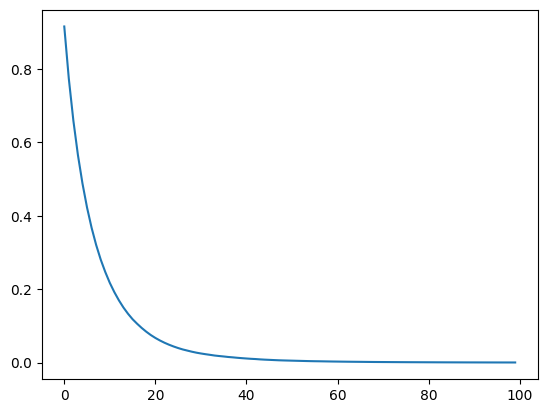

In [46]:
from matplotlib import pyplot as plt
plt.plot(GBC.train_score_) # 横轴是树的棵数，纵轴是误差，从图可以看到20-30棵树就差不多了
plt.show()

## 3.XGBoost
xgboost根据sklearn做了一个优化的包

In [47]:
#!pip install xgboost

In [48]:
from xgboost.sklearn import XGBClassifier
#from xgboost.sklearn import XGBRegressor
XGB = XGBClassifier()
XGB.fit(X,y1)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [49]:
XGB.feature_importances_

array([0.0095983 , 0.01644815, 0.6765867 , 0.2973669 ], dtype=float32)

In [50]:
XGB.predict_proba(X[:5])

array([[9.9680269e-01, 2.3830016e-03, 8.1426249e-04],
       [9.9636263e-01, 2.3819495e-03, 1.2554243e-03],
       [9.9680269e-01, 2.3830016e-03, 8.1426249e-04],
       [9.9679488e-01, 2.3829830e-03, 8.2212401e-04],
       [9.9680269e-01, 2.3830016e-03, 8.1426249e-04]], dtype=float32)

In [51]:
XGB.predict(X[:5])

array([0, 0, 0, 0, 0], dtype=int64)

In [52]:
np.asarray(y1[:5])

array([0, 0, 0, 0, 0], dtype=int64)

# Stacking算法
前面用了随机森林，Adaboost, GBDT, XGBoost。这里把这些模型的结果堆叠起来，获得一个更好的预测结果。

In [53]:
#!pip install mlxtend

In [54]:
from mlxtend.classifier import StackingClassifier
#Stacking第二阶段的方法选择逻辑回归
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
SC = StackingClassifier(classifiers = [ABC,GBC,XGB], meta_classifier =lr)
# 随机森林在这里没有训练所以就没加入了
SC.fit(X,y1)

StackingClassifier(classifiers=[AdaBoostClassifier(n_estimators=10),
                                GradientBoostingClassifier(),
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              gpu_id=None, grow_policy=None,...
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              objective='multi:softprob',
                                              predictor=None, ...)],
                   meta_classifier=LogisticRegression())

In [56]:
from sklearn.metrics import classification_report
print(classification_report(y1, SC.predict(X)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50
           2       1.00      1.00      1.00        50

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150

